## Probabilities of all classes of nucleotide substitution in the intergenic noncoding genome

[Aggarwala and Voight 2016](https://github.com/quinlan-lab/constraint-tools/blob/main/literature/germline/aggarwala%20and%20voight%202016/ng.3511.pdf) used 1000 genomes to compute the probabilities 
of all classes of nucleotide substitution in the intergenic noncoding genome (their Fig 2):


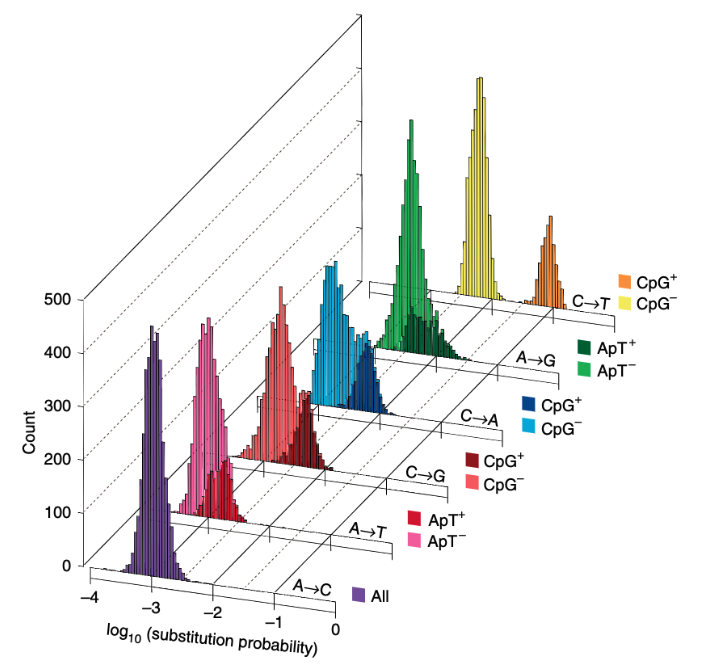

In [1]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='AggarwalaVoightFig2.png', width=1000)

We may do a similar analysis for the ~70,000 individuals in gnomad version 3: 

In [22]:
import json 
import numpy as np 
import matplotlib.pyplot as plt 

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

from kmer import ( 
  CpG, 
  ApT, 
  middle_base
)

def kmer_size(kmer_dict): 
  for kmer in kmer_dict.keys(): 
    return len(kmer)

def get_bar_width(bins): 
  return bins[1] - bins[0]

def get_bin_centers(bins): 
  return (bins[:-1] + bins[1:])/2

def get_kmer_probabilities(): 
  model = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'
  with open(model, 'r') as fh:
    return json.load(fh)['kmerProbabilities']

def get_logprobabilities_counts(ref_allele, alt_state, kmer_is_positive): 
  kmer_probabilities = get_kmer_probabilities() 
  
  log_probabilities_positive_class = []
  log_probabilities_negative_class = []
  for kmer, probabilities in kmer_probabilities.items():         
    if middle_base(kmer) == ref_allele:
      l = log_probabilities_positive_class if kmer_is_positive(kmer) else log_probabilities_negative_class
      l.append(np.log10(probabilities[alt_state]))

  logbins = np.linspace(-6, 0 , 150)
  counts_positive_class, logbins_positive_class = np.histogram(log_probabilities_positive_class, bins=logbins)
  counts_negative_class, logbins_negative_class = np.histogram(log_probabilities_negative_class, bins=logbins)
  return ( 
    get_bin_centers(logbins_positive_class), 
    counts_positive_class,
    get_bin_centers(logbins_negative_class), 
    counts_negative_class
  ) 

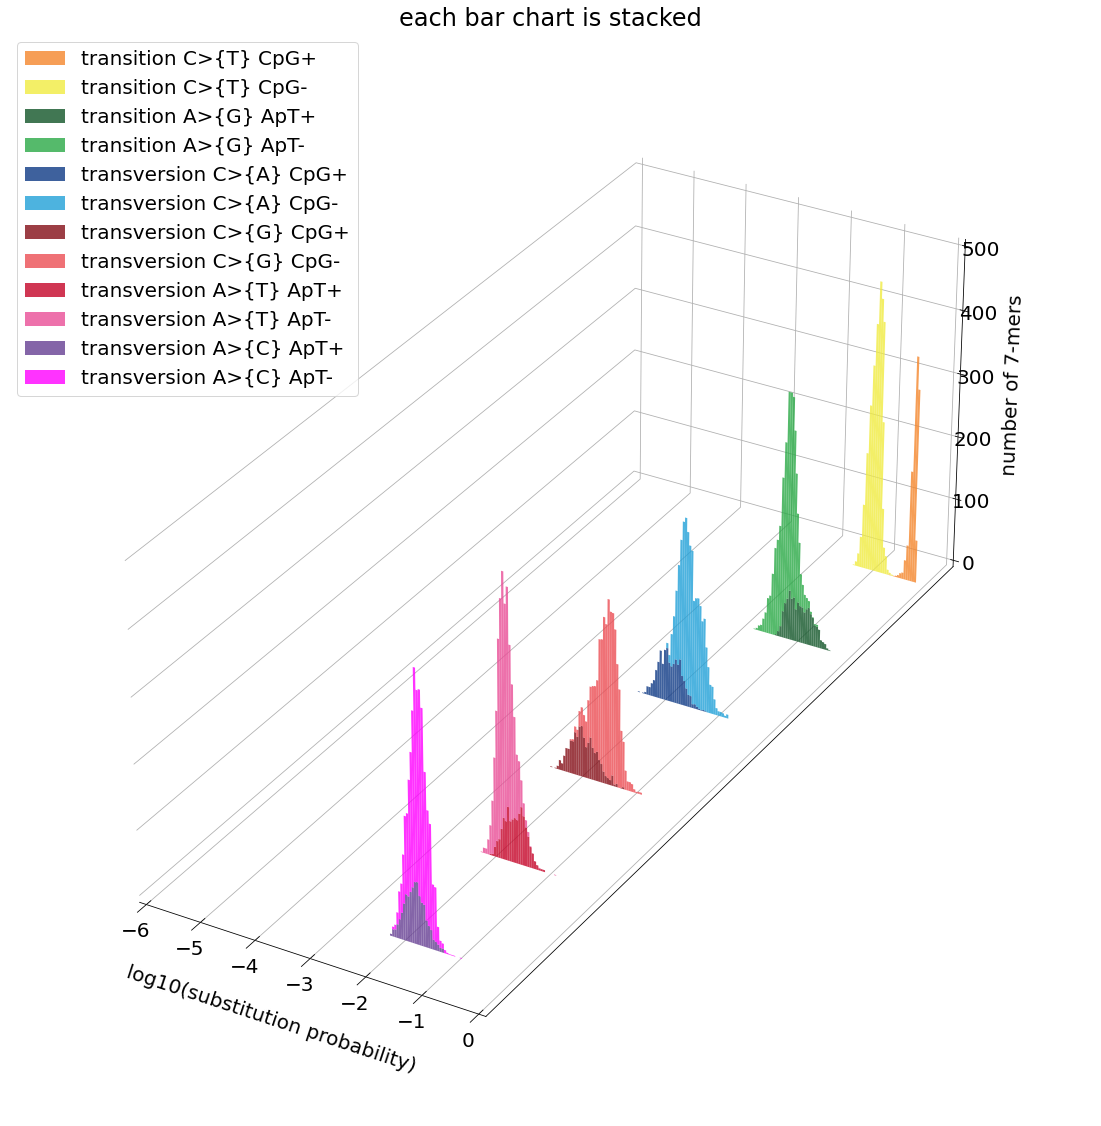

In [37]:
def get_alt_alleles(alt_state):
  return alt_state.strip('{}').split(',')

def get_transition_transversion_class(ref_allele, alt_allele): 
  # https://rosalind.info/glossary/transitiontransversion-ratio/

  if ref_allele == 'A' and alt_allele == 'G': return 'transition'
  if ref_allele == 'C' and alt_allele == 'T': return 'transition'

  if ref_allele == 'A' and alt_allele == 'C': return 'transversion'
  if ref_allele == 'A' and alt_allele == 'T': return 'transversion'
  if ref_allele == 'C' and alt_allele == 'A': return 'transversion'
  if ref_allele == 'C' and alt_allele == 'G': return 'transversion'

  raise ValueError

def plot_substitution_classes(colors, yticks, ref_alleles__alt_states__kmer_is_positive_functions, xlim, box_aspect=(1, 2.5, 1)):
  # https://matplotlib.org/stable/gallery/mplot3d/bars3d.html#sphx-glr-gallery-mplot3d-bars3d-py
  # https://stackoverflow.com/questions/35210337/can-i-plot-several-histograms-in-3d

  plt.rcParams.update({'font.size': 20})

  fig = plt.figure()
  fig.set_size_inches(40, 20)
  ax = fig.add_subplot(projection='3d')

  for (
    color, 
    ytick, 
    ref_allele__alt_state__kmer_is_positive_function
  ) in zip(
    colors, 
    yticks,
    ref_alleles__alt_states__kmer_is_positive_functions
  ):
    ref_allele, alt_state, kmer_is_positive = ref_allele__alt_state__kmer_is_positive_function

    alt_alleles = get_alt_alleles(alt_state)
    if len(alt_alleles) == 1: 
      label_prefix = f'{get_transition_transversion_class(ref_allele, alt_alleles[0])} '
    else: 
      label_prefix = ''

    label_prefix += f'{ref_allele}>{alt_state} {kmer_is_positive.__name__}'

    (
      log_probabilities_positive_class, 
      counts_positive_class,
      log_probabilities_negative_class, 
      counts_negative_class
    ) = get_logprobabilities_counts(ref_allele, alt_state, kmer_is_positive)
    color_positive_class, color_negative_class = color
    bar_width = get_bar_width(log_probabilities_positive_class)
    ax.bar(
      log_probabilities_positive_class, 
      counts_positive_class, 
      width=bar_width, 
      zs=ytick, 
      zdir='y', 
      color=color_positive_class, 
      edgecolor=None, 
      alpha=0.8,
      label=f'{label_prefix}+'
    )
    ax.bar(
      log_probabilities_negative_class, 
      counts_negative_class, 
      width=bar_width, 
      zs=ytick, 
      zdir='y', 
      color=color_negative_class, 
      edgecolor=None, 
      alpha=0.8, 
      bottom=counts_positive_class, 
      label=f'{label_prefix}-'
    )

  ax.set_xlabel('log10(substitution probability)', labelpad=20)

  ax.set_ylabel('')
  ax.set_zlabel('number of {}-mers'.format(kmer_size(get_kmer_probabilities())), labelpad=20)

  ax.set_xticks([-6, -5, -4, -3, -2, -1, 0])
  ax.set_yticks([])

  ax.set_xlim(xlim)
  ax.set_zlim([0, 500])

  ax.set_title('each bar chart is stacked')

  ax.set_box_aspect(box_aspect)

  white_rgba = (1.0, 1.0, 1.0, 1.0)
  ax.w_xaxis.set_pane_color(white_rgba)
  ax.w_yaxis.set_pane_color(white_rgba)
  ax.w_zaxis.set_pane_color(white_rgba)
  ax.legend(loc='upper left')

plot_substitution_classes(
  # first element in color tuple corresponds to positive class, e.g., CpG+
  # second element in color tuple corresponds to negative class, e.g., CpG-
  colors = [
    ('#F4862C', '#F0EB41'),
    ('#115528', '#2AA946'), 
    ('#0E3985', '#21A0D8'), 
    ('#840E17', '#EC4D54'), 
    ('#C50328', '#E94D96'), 
    ('#663F93', 'magenta')
  ],
  yticks = [5, 4, 3, 2, 1, 0],
  ref_alleles__alt_states__kmer_is_positive_functions = [
    ('C', '{T}', CpG),
    ('A', '{G}', ApT),
    ('C', '{A}', CpG),
    ('C', '{G}', CpG),
    ('A', '{T}', ApT),
    ('A', '{C}', ApT)  
  ],
  xlim = [-6, 0]
)

Notice that the x-axes in the two plots appear to be shifted relative to one another by about a factor of 10, which is consistent with the fact that size of the cohorts in both cases differ by about a factor of 10. 

The relative trends appear to be the same in both plots, apart from C > G and C > A, in which cases the CpG+ distribution appear to be on opposite sides of the CpG- distribution. Why might this be? 

One possible explanation relates to the fact that Aggarwala et al report maximum-a-posteriori estimators of substitution probabilies, whereas we compute only maximum-likelihood estimators. The procedure they use is described [here](https://photos.app.goo.gl/znSMF7AwUs7GWCXR7). Since the posterior estimators make use of substitution counts in coding regions, it is possible that coding-region specific trends propagate through to the posterior estimates in non-coding regions, explaining the discrepancy between Aggarwala et al's results and ours. 



<ipython-input-22-07c816cf1f68>:37: RuntimeWarning: divide by zero encountered in log10
  l.append(np.log10(probabilities[alt_state]))


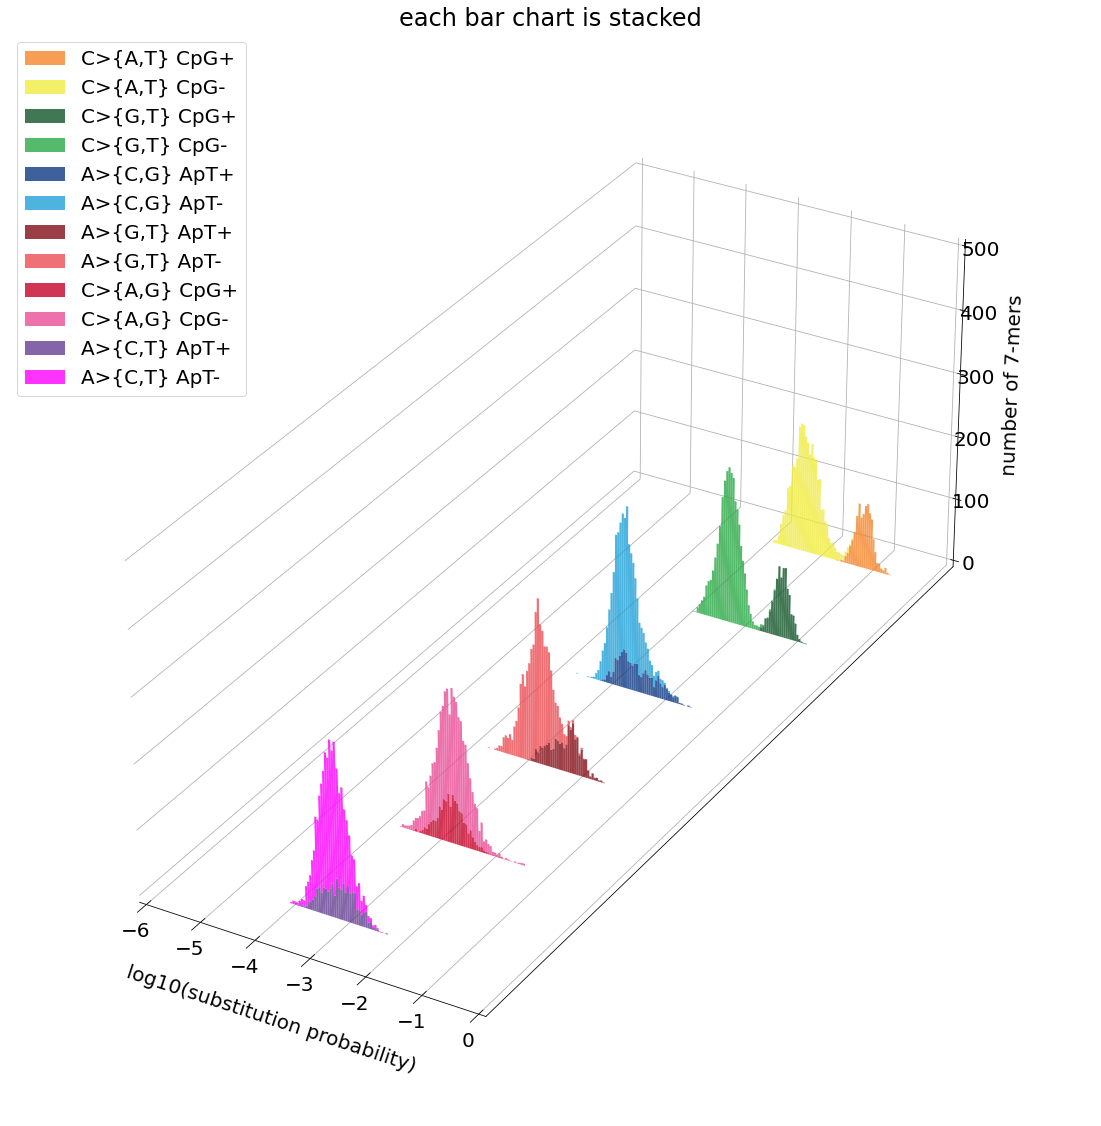

In [38]:
plot_substitution_classes(
  # first element in color tuple corresponds to positive class, e.g., CpG+
  # second element in color tuple corresponds to negative class, e.g., CpG-
  colors = [
    ('#F4862C', '#F0EB41'),
    ('#115528', '#2AA946'), 
    ('#0E3985', '#21A0D8'), 
    ('#840E17', '#EC4D54'), 
    ('#C50328', '#E94D96'), 
    ('#663F93', 'magenta')
  ],
  yticks = [5, 4, 3, 2, 1, 0],
  ref_alleles__alt_states__kmer_is_positive_functions = [
    ('C', '{A,T}', CpG),
    ('C', '{G,T}', CpG),
    ('A', '{C,G}', ApT),
    ('A', '{G,T}', ApT),  
    ('C', '{A,G}', CpG),
    ('A', '{C,T}', ApT)
  ],
  xlim = [-6, 0]
)


<ipython-input-22-07c816cf1f68>:37: RuntimeWarning: divide by zero encountered in log10
  l.append(np.log10(probabilities[alt_state]))


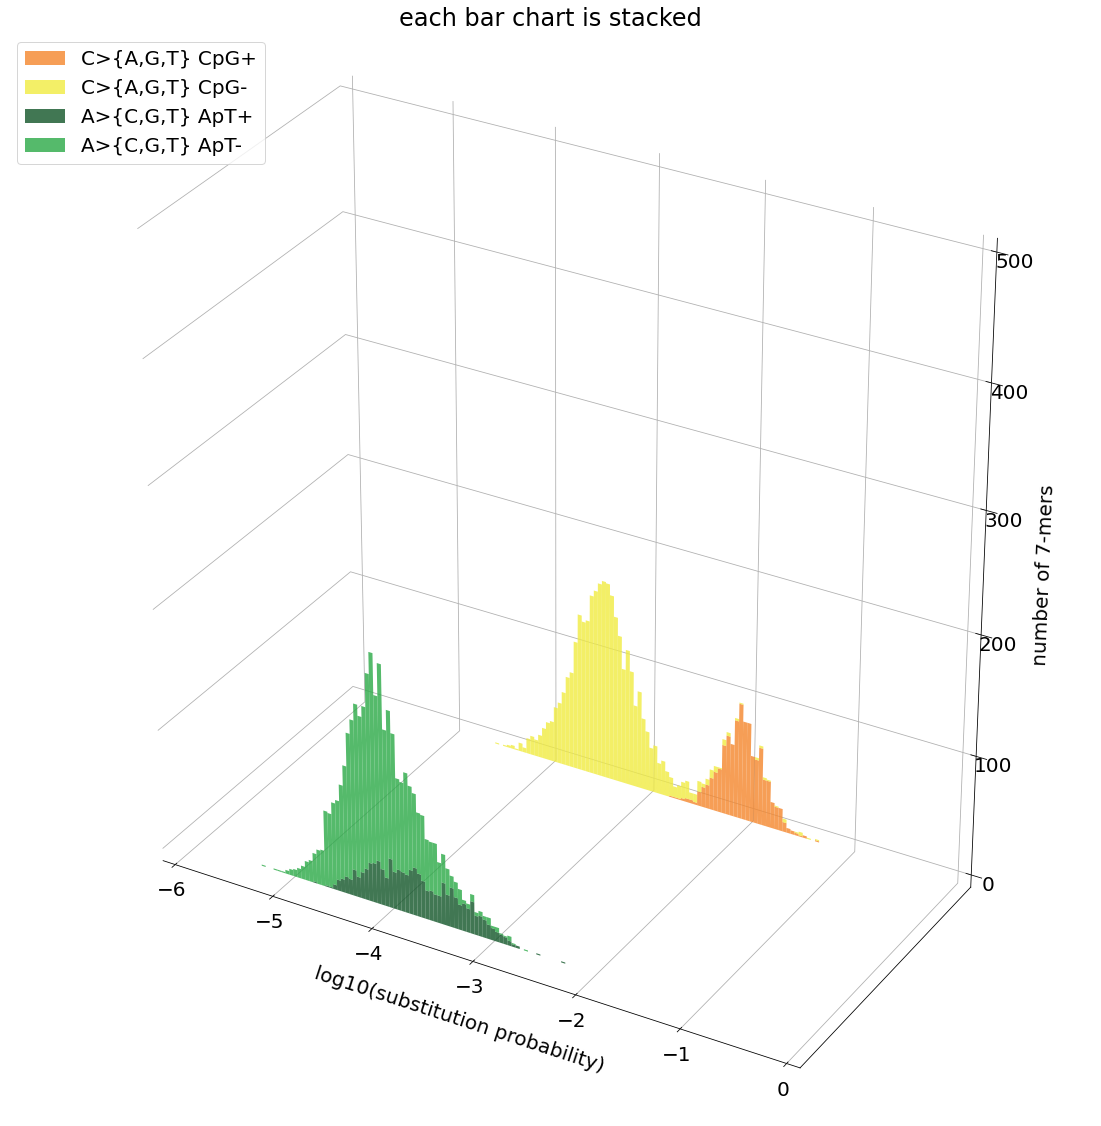

In [39]:
plot_substitution_classes(
  # first element in color tuple corresponds to positive class, e.g., CpG+
  # second element in color tuple corresponds to negative class, e.g., CpG-
  colors = [
    ('#F4862C', '#F0EB41'),
    ('#115528', '#2AA946')
  ],
  yticks = [1, 0],
  ref_alleles__alt_states__kmer_is_positive_functions = [
    ('C', '{A,G,T}', CpG),
    ('A', '{C,G,T}', ApT)
  ],
  xlim = [-6, 0],
  box_aspect=(1, 0.5, 1)
)


## Correlate substitution probabilities computed using kmers and their reverse complements

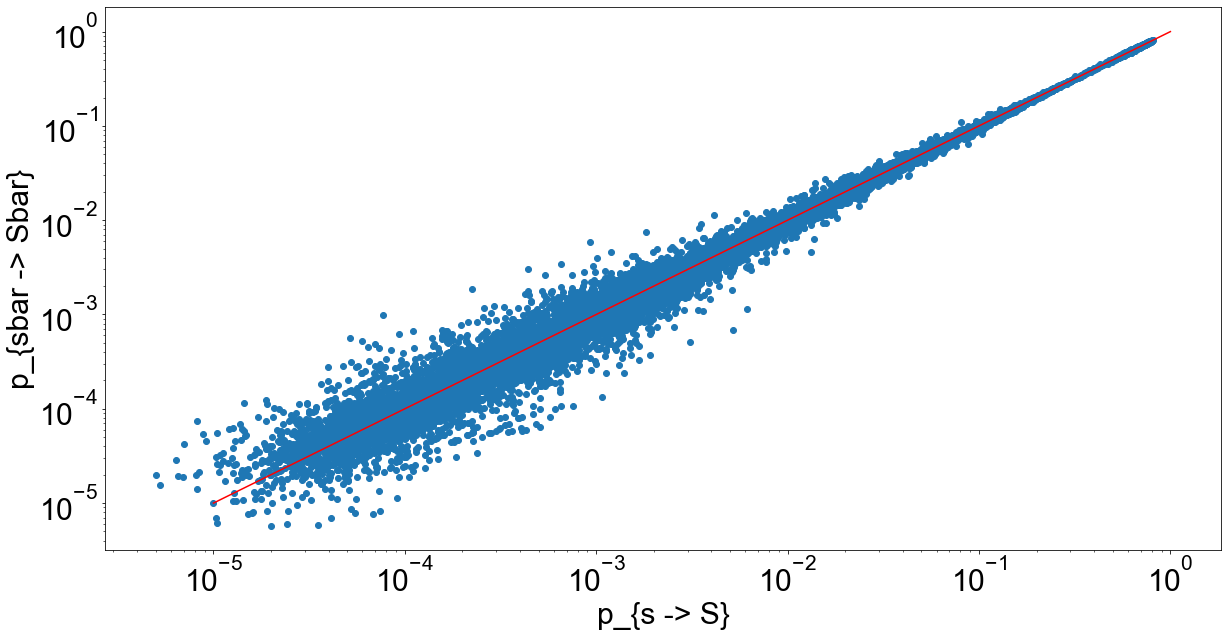

In [8]:
from kmer import ( 
  compute_kmers, 
  get_reverse_complement,
  compute_possible_ALT_states,
  get_complement
)

def get_counts(kmer_counts, kmer, ALT_state): 
  data = kmer_counts[kmer]
  return data['ALTStateCounts'][ALT_state], data['count'] 

def estimate_ALT_state_probability(kmer_counts, kmer, ALT_state): 
  # see define-model/germline-model.ipynb: 
  s_to_S_count, s_count = get_counts(kmer_counts, kmer, ALT_state)
  num = s_to_S_count 
  den = s_count 
  # estimate probabilities for multinomial distribution: https://math.stackexchange.com/a/421838
  return num/den if den > 0 else None

def estimate_kmer_probabilities(kmer_counts):
  xs, ys, labels = [], [], []
  kmers_visited = set()
  for kmer in compute_kmers(kmer_size(kmer_counts)): 
    if kmer in kmers_visited: continue
      
    kmer_bar = get_reverse_complement(kmer)
    kmers_visited.update({kmer, kmer_bar})

    for ALT_state in compute_possible_ALT_states(kmer):
      ALT_state_bar = get_complement(ALT_state)

      probability = estimate_ALT_state_probability(kmer_counts, kmer, ALT_state)
      xs.append(probability)

      probability_bar = estimate_ALT_state_probability(kmer_counts, kmer_bar, ALT_state_bar)
      ys.append(probability_bar)

      label = (kmer, ALT_state, kmer_bar, ALT_state_bar)
      labels.append(label)

  return xs, ys, labels


def get_kmer_counts(): 
  model = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'
  with open(model, 'r') as fh:
    return json.load(fh)['kmerCounts']

def plot_substitution_probabilities_using_kmer_and_kmerbar():
  kmer_counts = get_kmer_counts()
  xs, ys, labels = estimate_kmer_probabilities(kmer_counts)
  font = {
    'family': 'Arial',
    'weight': 'normal',
    'size': 30
  }
  import matplotlib
  matplotlib.rc('font', **font)  
  fig = plt.figure()
  fig.set_size_inches(20, 10)
  plt.scatter(xs, ys)
  plt.plot([1e-5, 1e0], [1e-5, 1e0], 'red')
  plt.xscale('log')
  plt.yscale('log')

  # See the model specification to interpret the x and y axis labels: 
  # https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb
  plt.xlabel('p_{s -> S}')
  plt.ylabel('p_{sbar -> Sbar}')

plot_substitution_probabilities_using_kmer_and_kmerbar()